# Baltimore shootings analysis by district

By [Statwonk](https://twitter.com/statwonk)

Analysis of the relationship between District and shootings in Baltimore

## Import R data analysis libraries

In [1]:
suppressMessages(library('tidyverse'))
suppressMessages(library('lubridate'))

Warning message:
“package ‘dplyr’ was built under R version 3.5.1”

## Data processing:

In [2]:
suppressWarnings({
    readr::read_csv("BPD_Part_1_Victim_Based_Crime_Data.csv", 
                                           progress = FALSE, 
                                           col_types = cols())
}) %>%
mutate(date = lubridate::mdy(CrimeDate),
       date = as.POSIXct(date, origin = "1970-01-01")) %>%
filter((Description == 'SHOOTING' | Description == 'HOMICIDE') & Weapon == 'FIREARM') %>%
  distinct(Location, date, .keep_all = TRUE) %>% # the data are rife with coding errors like duplicates.
  count(District, date) %>%
  mutate(max_date = max(date, na.rm = TRUE)) %>%
  tidyr::complete(tidyr::nesting(District), 
                  date = tidyr::full_seq(sort(unique(c(date, max_date))), 60*60*24),
                  fill = list(n = 0)) %>%
  rename(shootings = n) %>% 
  dplyr::select(-max_date) -> shootings

## Data analysis:

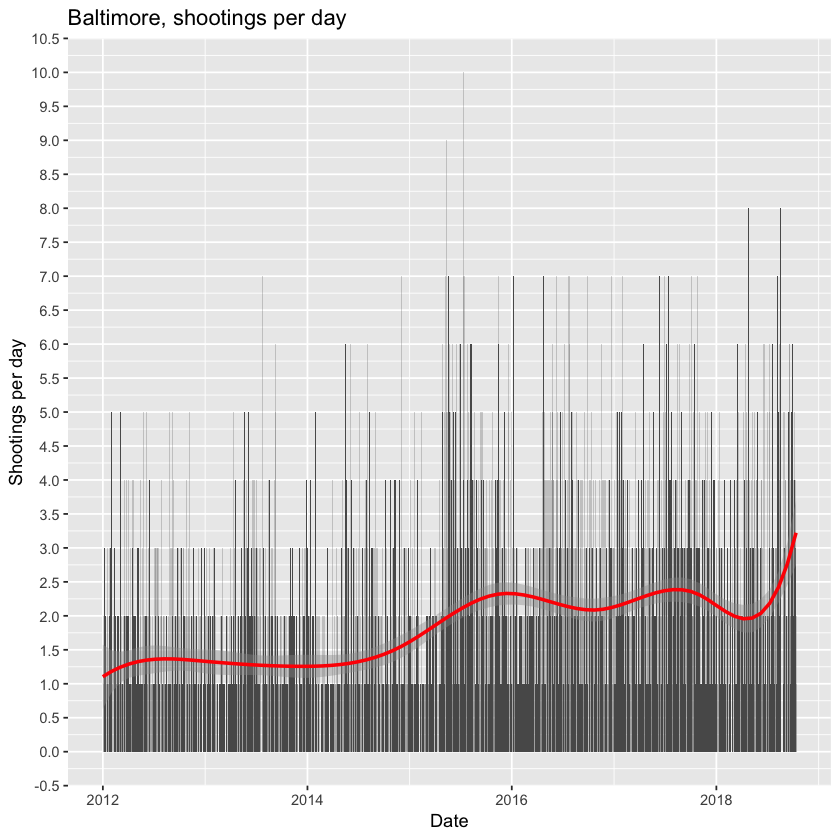

In [3]:
library("ggplot2")
ggplot(shootings %>% group_by(date) %>% summarise(n = sum(shootings)), aes(x = date, y = n)) + 
    geom_bar(stat = "identity") +
    geom_smooth(method = "gam", formula = y ~ s(x, bs = "ps"), colour = "red") +
    ylab("Shootings per day") +
    ggtitle("Baltimore, shootings per day") +
    scale_y_continuous(labels = scales::comma, breaks =  scales::pretty_breaks(20)) +
    xlab("Date")

We can fit both a Poisson and Negative Binomial generalized linear model. The Poisson model is nested within the Negative Binomial model (see http://statwonk.com/negative-binomial-gamma.html). We can test if the extra parameter "theta" has explanatory power worth more than the cost of a more complex model (occam's razor prefering simpler models and explainations).

In [4]:
# install.packages("MASS")
shootings %>%
  group_by(date) %>% summarise(shootings = sum(shootings)) %>%
  mutate(trend = 1:n()) %>%
  glm(shootings ~ trend, data = ., family = "poisson") %>%
  logLik() -> poisson_log_likelihood

shootings %>%
  group_by(date) %>% summarise(shootings = sum(shootings)) %>%
  mutate(trend = 1:n()) %>%
  MASS::glm.nb(shootings ~ trend, data = .) %>%
  logLik() -> negbin_log_likelihood

logLik(poisson_log_likelihood)
logLik(negbin_log_likelihood)

stat <- as.numeric(2 * (negbin_log_likelihood - poisson_log_likelihood))
 # https://stats.stackexchange.com/a/128640/11509
message("p-value of likelihood ratio test: ", pchisq(stat, df = 5 - 4, lower.tail = FALSE))

'log Lik.' -4181.967 (df=2)

'log Lik.' -4162.777 (df=3)

p-value of likelihood ratio test: 5.82483460513206e-10


In [5]:
shootings %>%
  group_by(date) %>% summarise(shootings = sum(shootings)) %>%
  mutate(trend = 1:n()) %>%
  MASS::glm.nb(shootings ~ trend, data = .) -> nbfit

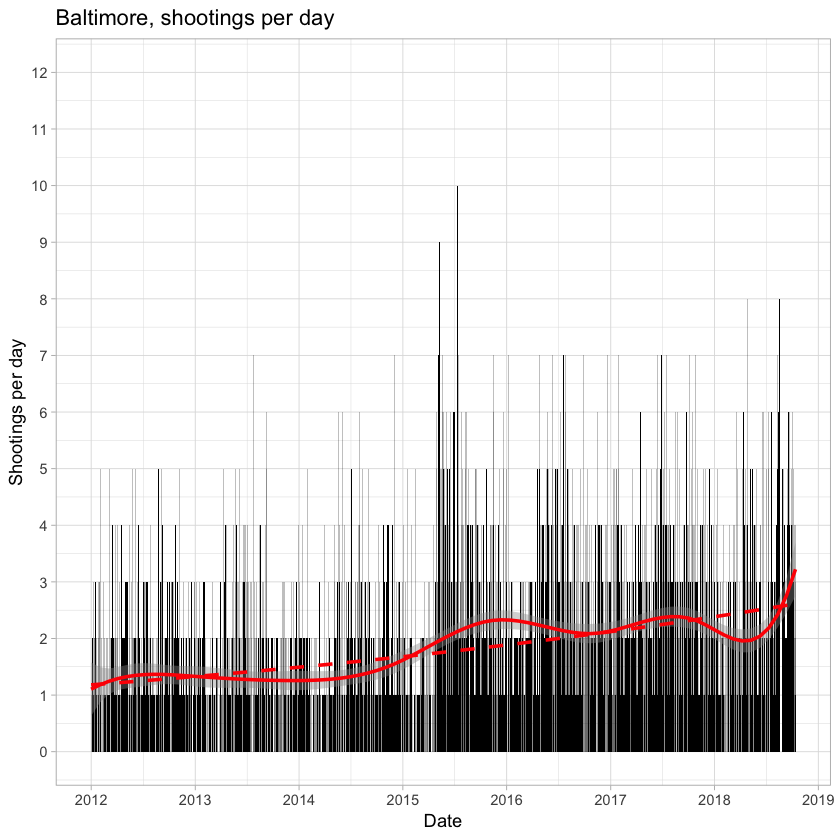

In [6]:
shootings %>%
  group_by(date) %>% 
  summarise(shootings = sum(shootings)) %>% 
  mutate(trend = 1:n()) %>% 
  mutate(pred = predict(nbfit, newdata = ., type = "response")) %>%
  ggplot(aes(x = date)) +
  geom_bar(aes(y = shootings), stat = "identity", fill = "black") +
  geom_smooth(aes(y = shootings), method = "gam", formula = y ~ s(x, bs = "ps"), colour = "red") +
  geom_line(aes(y = pred), colour = "red", size = 1, linetype = "dashed") + # a prediction from the negative binomial
  ylab("Shootings per day") +
  ggtitle("Baltimore, shootings per day") +
  scale_y_continuous(labels = scales::comma, breaks =  scales::pretty_breaks(10)) +
  xlab("Date") +
  scale_x_datetime(labels = scales::date_format("%Y"), breaks = scales::date_breaks("1 year")) +
  coord_cartesian(ylim = c(0, 12)) +
  theme_light()

In [7]:
nbfit %>% summary()


Call:
MASS::glm.nb(formula = shootings ~ trend, data = ., init.theta = 9.76841259, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1420  -0.8280  -0.2264   0.5039   3.6375  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) 1.662e-01  3.579e-02   4.645 3.41e-06 ***
trend       3.203e-04  2.313e-05  13.850  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(9.7684) family taken to be 1)

    Null deviance: 2986.6  on 2477  degrees of freedom
Residual deviance: 2792.8  on 2476  degrees of freedom
AIC: 8331.6

Number of Fisher Scoring iterations: 1


              Theta:  9.77 
          Std. Err.:  1.82 

 2 x log-likelihood:  -8325.555 

In [8]:
shootings %>%
  group_by(District, date) %>% 
  summarise(shootings = sum(shootings)) %>%
  arrange(date) %>%
  mutate(trend = 1:n()) %>%
  ungroup() %>%
  mutate(District = factor(District)) -> data_by_district

Below two models are fit. Both have a trend term in common. The second model has [Police] District added. Afterwards we can view the AIC statistics and see that indeed police districts have different rates of shootings.

In [9]:
data_by_district %>%
  MASS::glm.nb(shootings ~ trend, data = .) -> fit

data_by_district %>%
  MASS::glm.nb(shootings ~ trend + District, data = .) -> fit_by_district

AIC(fit)
AIC(fit_by_district)

[1] 23855.61

[1] 23381.53

In [10]:
summary(fit_by_district)


Call:
MASS::glm.nb(formula = shootings ~ trend + District, data = ., 
    init.theta = 5.067817765, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9243  -0.6760  -0.5589  -0.4280   4.0141  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -2.567e+00  6.673e-02 -38.472  < 2e-16 ***
trend                 3.193e-04  2.171e-05  14.709  < 2e-16 ***
DistrictEASTERN       7.703e-01  7.220e-02  10.669  < 2e-16 ***
DistrictNORTHEASTERN  6.408e-01  7.371e-02   8.693  < 2e-16 ***
DistrictNORTHERN      5.397e-02  8.297e-02   0.651    0.515    
DistrictNORTHWESTERN  6.146e-01  7.403e-02   8.302  < 2e-16 ***
DistrictSOUTHEASTERN -8.250e-02  8.580e-02  -0.962    0.336    
DistrictSOUTHERN      5.176e-01  7.531e-02   6.873 6.31e-12 ***
DistrictSOUTHWESTERN  7.943e-01  7.193e-02  11.042  < 2e-16 ***
DistrictWESTERN       9.677e-01  7.019e-02  13.788  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘

![Baltimore Police Districts](https://www.baltimorepolice.org/sites/default/files/images/Districts-Map2.jpg)

In [11]:
fit_by_district %>%
  coef() %>%
  as.data.frame() %>%
  tibble::rownames_to_column(var = "coefficient") %>%
  rename(value = 2) %>%
  mutate_if(is.numeric, exp) %>%
  arrange(desc(value))

coefficient,value
DistrictWESTERN,2.63197204
DistrictSOUTHWESTERN,2.21290300
DistrictEASTERN,2.16033988
DistrictNORTHEASTERN,1.89790552
DistrictNORTHWESTERN,1.84893450
DistrictSOUTHERN,1.67791737
DistrictNORTHERN,1.05545417
trend,1.00031932
DistrictSOUTHEASTERN,0.92081056
(Intercept),0.07675632


From the model negbin(shootings "as a function of:" district, day of week, a trend and intercept), it's possble to see that the police districts with the most shootings are the Western, Southwestern and Eastern districts.

Now, let's see if the trends are different by district.

In [12]:
data_by_district %>%
  MASS::glm.nb(shootings ~ trend + District, data = .) -> fit_by_district

data_by_district %>%
  MASS::glm.nb(shootings ~ trend*District, data = .) -> fit_by_district_by_trend

AIC(fit_by_district)
AIC(fit_by_district_by_trend)

[1] 23381.53

[1] 23384.81

In [13]:
summary(fit_by_district_by_trend)


Call:
MASS::glm.nb(formula = shootings ~ trend * District, data = ., 
    init.theta = 5.145724478, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9212  -0.6780  -0.5575  -0.4311   4.0287  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -2.593e+00  1.329e-01 -19.517  < 2e-16 ***
trend                       3.378e-04  8.448e-05   3.999 6.36e-05 ***
DistrictEASTERN             9.090e-01  1.595e-01   5.698 1.21e-08 ***
DistrictNORTHEASTERN        7.781e-01  1.627e-01   4.781 1.74e-06 ***
DistrictNORTHERN            1.435e-01  1.835e-01   0.782   0.4342    
DistrictNORTHWESTERN        6.845e-01  1.644e-01   4.165 3.12e-05 ***
DistrictSOUTHEASTERN       -4.012e-02  1.908e-01  -0.210   0.8334    
DistrictSOUTHERN            2.993e-01  1.719e-01   1.741   0.0817 .  
DistrictSOUTHWESTERN        7.110e-01  1.617e-01   4.396 1.10e-05 ***
DistrictWESTERN             1.003e+00  1.563e-01   6.418 1

The result is no evidence that the trend is different between the districts. Let's convert to monthly interval, so the rates are a bit clearer.

In [14]:
data_by_district %>%
  mutate(date = as.POSIXct(format(date, "%Y-%m-01"), origin = "1970-01-01")) %>%
  group_by(District, date) %>%
  summarise(shootings = sum(shootings)) %>%
  group_by(District) %>% arrange(date) %>%
  mutate(trend = 1:n()) %>%
  ungroup() -> data_by_month

data_by_month %>% head()

District,date,shootings,trend
CENTRAL,2011-12-01,0,1
EASTERN,2011-12-01,0,1
NORTHEASTERN,2011-12-01,0,1
NORTHERN,2011-12-01,1,1
NORTHWESTERN,2011-12-01,0,1
SOUTHEASTERN,2011-12-01,0,1


In [15]:
MASS::glm.nb(shootings ~ trend + District, data = data_by_month) -> fit_by_district_by_month 

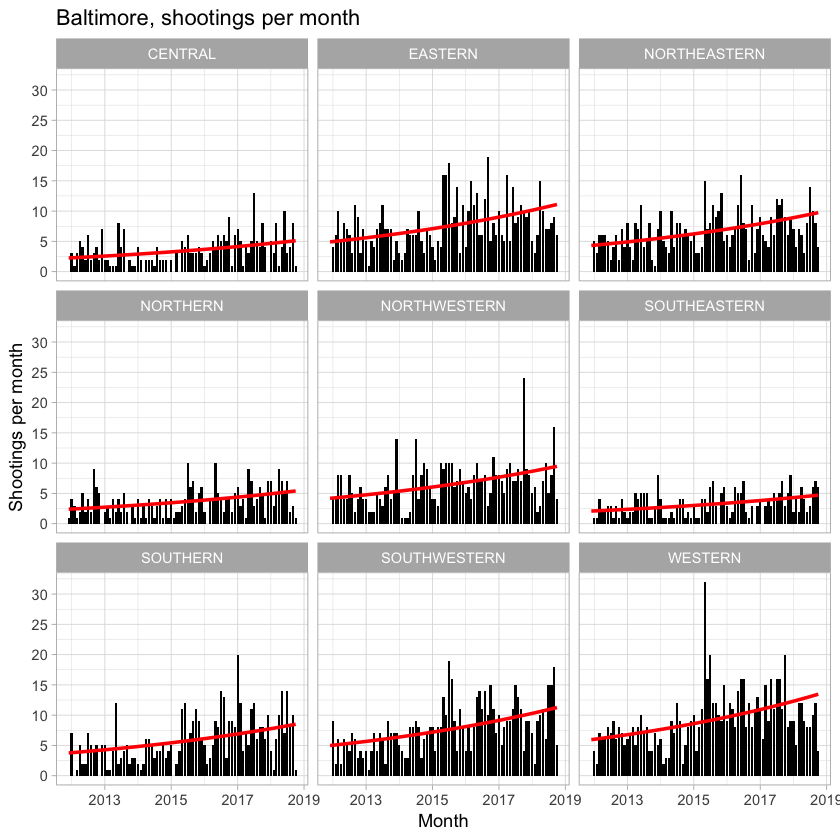

In [16]:
data_by_month %>%
  mutate(pred = predict(fit_by_district_by_month, newdata = ., type = "response")) %>%
  ggplot(aes(x = date)) +
  geom_bar(aes(y = shootings), stat = "identity", fill = "black") +
  geom_line(aes(y = pred), colour = "red", size = 1) + # a prediction from the negative binomial
  ylab("Shootings per month") +
  ggtitle("Baltimore, shootings per month") +
  scale_y_continuous(labels = scales::comma, breaks =  scales::pretty_breaks(10)) +
  xlab("Month") +
  scale_x_datetime(labels = scales::date_format("%Y"), breaks = scales::date_breaks("2 year")) +
  theme_light() +
  facet_wrap(~ District)